# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 2D problem

### Manufactured solution


We use $u = x^2 + y^2$ for $x\in [-1,1]^2$ to manufacture the right hand side to be $f=4$ which is same as $f=-\Delta u$.

### Importing packages

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [35]:
np.random.seed(123)
pde_data_size = 10000
dim_d = 2
X_tr_pde = np.random.uniform(-2,2,pde_data_size*dim_d).reshape(pde_data_size,dim_d)


### Looking at the scatter plot of genrated 2d points

Text(0.5, 1.0, 'Randomly generated collocation points')

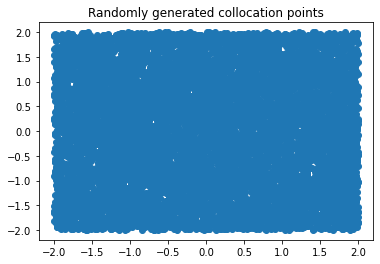

In [36]:
plt.scatter(X_tr_pde[:,0],X_tr_pde[:,1])
plt.title("Randomly generated collocation points")

### Defining RHS of pde

In [37]:
Y_tr_pde = -4*np.ones((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [38]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(10000, 2)

### Experiment with surface plotting( might help later while plotting the computed solution)

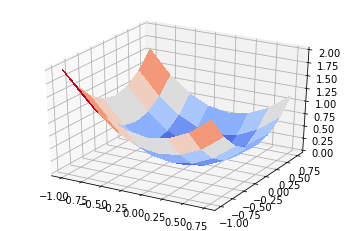

In [39]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


## BC data 

In [8]:
bc_data_size = 500

X_bc_left = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([-1*np.ones((bc_data_size,1)), X_bc_left], axis=1)

X_bc_bottom = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, -1*np.ones((bc_data_size,1))], axis=1)

X_bc_right = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([1*np.ones((bc_data_size,1)), X_bc_right], axis=1)

X_bc_top = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, 1*np.ones((bc_data_size,1))], axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top],axis=0)

In [9]:
Y_bc = X_bc[:,0:1]**2 + X_bc[:,1:]**2 
Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [10]:
dom_data_size = 1000
X_domain  = np.random.uniform(-1,1,dom_data_size*dim_d).reshape(dom_data_size,dim_d)

Y_domain = X_domain[:,0:1]**2 + X_domain[:,1:]**2 
Y_domain = np.concatenate([Y_domain, np.ones((Y_domain.shape[0],1))], axis=1)

In [11]:
X_tr = np.concatenate((X_tr_pde, X_bc, X_domain), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_bc, Y_domain), axis=0)

## Training the model

In [40]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(20, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(20, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(20, activation="elu",
                                         name="dense_3")
        self.dense_4 = keras.layers.Dense(1,
                                         name="dense_4")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("error occured in find gradient lambda layer of type {} as follows: ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: ".format(type(e)),e)
        
    def findPdeLayer(self,pde_lhs,input_arg):
        return keras.layers.Lambda(lambda z: z[0] -4) ([pde_lhs, input_arg])
    
    
    def call(self, inputs):
        inputs_conc = keras.layers.concatenate(inputs) 
        layer_1 = self.dense_1(inputs_conc)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        layer_4 = self.dense_4(layer_3)
        
        grad_layer = self.findGrad(layer_4, inputs)
        laplace_layer = self.findSecGrad(grad_layer, inputs)
        pde_layer = self.findPdeLayer(laplace_layer, inputs)
        
        return layer_4, pde_layer




In [41]:
custom_model = CustomModel()

In [42]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
#     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_pred)
#     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

In [43]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer="adam", loss_weights=[0.5,0.5])
# custom_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [22]:
custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
407/407 [==============================] - 3s 7ms/step - loss: 0.5097 - output_1_loss: 0.0357 - output_2_loss: 0.9836
Epoch 2/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0346 - output_1_loss: 0.0018 - output_2_loss: 0.0675
Epoch 3/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0227 - output_1_loss: 6.8811e-04 - output_2_loss: 0.0447
Epoch 4/10
407/407 [==============================] - 3s 8ms/step - loss: 0.0185 - output_1_loss: 8.2217e-04 - output_2_loss: 0.0362
Epoch 5/10
407/407 [==============================] - 3s 8ms/step - loss: 0.0182 - output_1_loss: 0.0010 - output_2_loss: 0.0355
Epoch 6/10
407/407 [==============================] - 4s 9ms/step - loss: 0.0229 - output_1_loss: 0.0019 - output_2_loss: 0.0439
Epoch 7/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0215 - output_1_loss: 0.0016 - output_2_loss: 0.0414
Epoch 8/10
407/407 [==============================] - 3s 7ms/step - loss: 0.0176 - output

In [23]:
# custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
# custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

### Testing the model

In [24]:
X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [25]:
X_test_st = np.random.uniform(-1,1,20*dim_d).reshape(20,dim_d)


In [26]:

#custom_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y=[Y_tr[-100:,:], Y_tr[-100:,:]])

In [27]:
Y_test = custom_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2]])[0]
Y_test

array([[1.3391109 ],
       [1.9219308 ],
       [0.8329244 ],
       [0.54641324],
       [0.4680042 ],
       [0.07680926],
       [0.89054686],
       [0.58833635],
       [0.28767836],
       [0.29325506],
       [0.4507951 ],
       [1.4682169 ],
       [0.21210817],
       [0.3288678 ],
       [0.20329982],
       [1.3221123 ],
       [0.12200025],
       [0.9331091 ],
       [1.0408142 ],
       [0.05776906]], dtype=float32)

In [31]:
Y_test_true = X_test_st[:,0:1]**2 + X_test_st[:,1:2]**2

In [32]:
np.concatenate([Y_test_true, Y_test], axis=1)

array([[1.28489137, 1.33911085],
       [1.94458337, 1.92193079],
       [0.8085577 , 0.83292443],
       [0.5291978 , 0.54641324],
       [0.42828601, 0.4680042 ],
       [0.05851205, 0.07680926],
       [0.88948052, 0.89054686],
       [0.57528452, 0.58833635],
       [0.25968744, 0.28767836],
       [0.26951398, 0.29325506],
       [0.44632917, 0.45079511],
       [1.48354931, 1.4682169 ],
       [0.17834979, 0.21210817],
       [0.28763636, 0.32886779],
       [0.19157383, 0.20329982],
       [1.30232673, 1.32211232],
       [0.10179827, 0.12200025],
       [0.92656399, 0.9331091 ],
       [1.03248877, 1.04081416],
       [0.03822843, 0.05776906]])

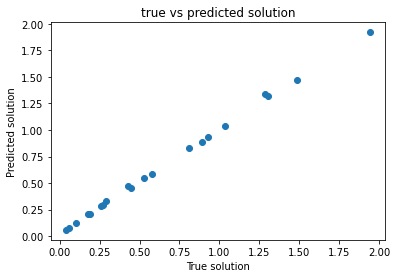

In [34]:
plt.scatter(Y_test_true,Y_test)
plt.title("true vs predicted solution")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

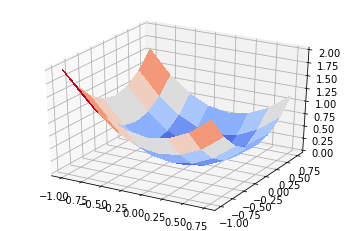

In [57]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
